# Data preprocessing (split to new Notebook later)
Here we throw away simulation data so we can focus on the *scores* only.

In [1]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:42443 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 15.54 GiB


In [2]:
base_path = '../data/parameter_search/2021-03-19/'

no_curves_dfs = []
for f in ['A', 'B', 'C']:
    df = dd.read_parquet(base_path + f'{f}_augmented.parquet', engine='pyarrow')  # Just to get columns
    df = dd.read_parquet(base_path + f'{f}_augmented.parquet', engine='pyarrow', columns=[col for col in df.columns if col not in ['time', 'y_diff', 'emf']]).drop_duplicates()
    df['input_excitation'] = df['input_excitation'].astype('int')
    df['device_id'] = f.split('.')[0]
    no_curves_dfs.append(df)
    
dd.concat(no_curves_dfs).to_parquet('no_curves.parquet', engine='pyarrow', compression='snappy')

In [3]:
client.close()

---

In [4]:
from dask.distributed import Client
import dask.dataframe as dd

client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:37575 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 24 Memory: 33.64 GB


In [5]:
root_path = './'
files_prefix = ['A', 'B', 'C']

In [6]:
dfs = []
for f in files_prefix:
    df = dd.read_parquet(root_path + f + '.parquet', engine='pyarrow')
    df['device_id'] = f
    df['input_excitation'] = df['input_excitation'].astype('int')
    dfs.append(df)
len(dfs)

3

In [7]:
dd.concat(dfs).to_parquet(root_path + 'joined.parquet', engine='pyarrow', partition_on=['device_id', 'input_excitation'], compression='brotli')

In [8]:
client.close()

# Start here
Once you've processed your data, of course.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [49]:
df2 = pd.read_parquet('no_curves.parquet/').reset_index(drop=True)
df2_filtered = df2
df2.head()

,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,emf_dtw_euclid_norm,emf_dtw_dist,rms_perc_diff_detrend,y_diff_dtw_euclid_norm,input_excitation,device_id
0,2760,18.700601,133.169589,157.964705,2.921429,0.008333,0.000000,2.5,12.5,30,0.046258,115.922960,125.703399,0.007427,0,A
1,2761,21.940940,139.772444,196.025229,2.921429,0.008333,0.833333,2.5,12.5,30,0.047646,119.400057,132.071632,0.007852,0,A
2,2762,21.296333,142.810498,172.046788,2.921429,0.008333,1.666667,2.5,12.5,30,0.048505,121.602356,134.795619,0.007731,0,A
3,2763,20.414750,147.851987,161.375682,2.921429,0.008333,2.500000,2.5,12.5,30,0.049124,127.034041,139.693449,0.008095,0,A
4,2764,20.245012,151.665201,169.053189,2.921429,0.008333,3.333333,2.5,12.5,30,0.047855,128.633259,143.109502,0.008040,0,A


# Feature engineering
Here we calculate all our objective functions that we use to estimate the performance of each set of model parameters.

We also calculate norms, which have the form: $F_{\text{norm}} = \frac{F - \text{min}(F)}{\text{max}(F) - \text{min}(F)}$, which theoretically compresses values between 0 and 1.

In [50]:

# Do some shuffling of the columns
df2_filtered['dtw_mech'] = df2_filtered['y_diff_dtw_euclid_norm']
df2_filtered['dtw_elec'] = df2_filtered['emf_dtw_euclid_norm'] 
df2_filtered['rms_perc_diff'] = df2_filtered['rms_perc_diff_detrend']

def calc_norm(series):
    """Calculate the norm of a metric."""
    return (series - series.min())/(series.max() - series.min())

# Norm and objective function calculation
df2_filtered['rms_perc_abs'] = np.abs(df2_filtered['rms_perc_diff'])
df2_filtered['dtw_mech_norm'] = calc_norm(df2_filtered['dtw_mech'])
df2_filtered['dtw_elec_norm'] = calc_norm(df2_filtered['dtw_elec'])
df2_filtered['rms_perc_abs_norm'] = calc_norm(df2_filtered['rms_perc_abs'])

df2_filtered['dtw_both'] = df2_filtered['dtw_mech_norm'] + df2_filtered['dtw_elec_norm']
df2_filtered['rms_dtw_elec'] = df2_filtered['rms_perc_abs_norm'] + df2_filtered['dtw_elec_norm']
df2_filtered['balanced'] = df2_filtered['rms_perc_abs_norm'] + df2_filtered['dtw_mech_norm'] + df2_filtered['dtw_elec_norm']

df2_filtered = df2_filtered.reset_index(drop=True)
df2_filtered.head()

,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,...,device_id,dtw_mech,dtw_elec,rms_perc_abs,dtw_mech_norm,dtw_elec_norm,rms_perc_abs_norm,dtw_both,rms_dtw_elec,balanced
0,2760,18.700601,125.703399,157.964705,2.921429,0.008333,0.000000,2.5,12.5,30,...,A,0.007427,0.046258,125.703399,0.318732,0.014946,0.037588,0.333677,0.052534,0.371266
1,2761,21.940940,132.071632,196.025229,2.921429,0.008333,0.833333,2.5,12.5,30,...,A,0.007852,0.047646,132.071632,0.339531,0.015542,0.039493,0.355074,0.055035,0.394566
2,2762,21.296333,134.795619,172.046788,2.921429,0.008333,1.666667,2.5,12.5,30,...,A,0.007731,0.048505,134.795619,0.333632,0.015912,0.040307,0.349544,0.056219,0.389851
3,2763,20.414750,139.693449,161.375682,2.921429,0.008333,2.500000,2.5,12.5,30,...,A,0.008095,0.049124,139.693449,0.351447,0.016178,0.041772,0.367625,0.057950,0.409397
4,2764,20.245012,143.109502,169.053189,2.921429,0.008333,3.333333,2.5,12.5,30,...,A,0.008040,0.047855,143.109502,0.348759,0.015632,0.042793,0.364391,0.058426,0.407184


# Remove outliers
Anything more than 3 standard deviations out we consider outliers, and remove from the dataset.

We don't want to skew our results using severe outliers that can sometimes occur due to buggy simulations with particularly bad parameters.

In [51]:
def drop_outliers(criteria: str, df) -> pd.DataFrame:
    percent_samples = 0.9745  # Outside of 2/3 standard deviations
    cut_off = (1-percent_samples)/2
    upper_bound = df[criteria].quantile(percent_samples)
    lower_bound = df[criteria].quantile(1-(percent_samples + cut_off))

    to_drop_lower = df.query(f'{criteria} < {lower_bound}')['model_id'].values
    to_drop_upper = df.query(f'{criteria} > {upper_bound}')['model_id'].values

    to_drop = np.concatenate([to_drop_lower, to_drop_upper])

    return df[~df2_filtered['model_id'].isin(to_drop)]

In [52]:
df2_filtered = drop_outliers(criteria='dtw_both', df=df2_filtered)
print(len(df2))
len(df2_filtered)

157500


96705

<AxesSubplot:ylabel='Frequency'>

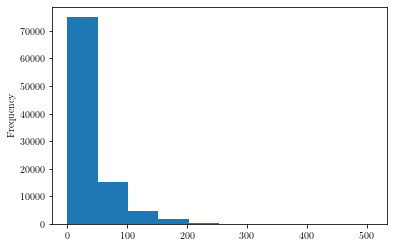

In [54]:
df2_filtered['rms_perc_abs'].plot(kind='hist')

## Additional outlier removal
Certain input excitations cause all model parameters to simulate poorly. 

This is a bit of a luck of the draw, and has to do with how the base plate was held during experimentation. We remove these since they're "bad" tests that do not represent the actual behaviour in practice.

In [55]:
which_filter = 'dtw_both'
df2_filtered.query('device_id == "A"').groupby(['input_excitation']).agg({'balanced': 'mean', which_filter: 'mean'}).style.background_gradient(cmap='Reds')

,balanced,dtw_both
input_excitation,,
0,0.302617,0.276153
1,0.199813,0.185064
2,0.165602,0.154684
3,0.191739,0.172101
4,0.170237,0.157644
5,0.180284,0.168476
6,0.177984,0.161584


In [56]:
def which_inputs_to_drop(df, device, number_to_drop):
    return (
        df
        .query(f'device_id == "{device}"')
        .groupby(['device_id', 'input_excitation'])
        .agg({which_filter: 'mean'})
        .sort_values(by=which_filter, ascending=False)
        .reset_index()
        .iloc[:number_to_drop, :]['input_excitation']
        .values
    )

indexes_to_drop = []
for device, num in zip(['A', 'B', 'C'], [1, 2, 2]):
    to_drop = which_inputs_to_drop(df2_filtered, device, num)
    print(to_drop)
    x = df2_filtered[df2_filtered['input_excitation'].isin(to_drop)]
    x = x[x['device_id'] == device]
    indexes_to_drop.append(x.index)
    
for idx in indexes_to_drop:
    df2_filtered = df2_filtered.drop(idx)

[0]
[2 6]
[2 6]


In [57]:
len(df2_filtered)

73680

In [58]:
df2_filtered = df2_filtered.drop(df2_filtered.query('input_excitation == 4 and device_id == "A"').index)

In [59]:
len(df2_filtered)

69075

# Get the best parameter set for each objective function

In [60]:
df_scores = df2_filtered.groupby(['model_id']).agg({
    'dtw_mech': 'mean',
    'dtw_elec': 'mean',
    'dtw_both': 'mean',
    'rms_perc_abs': 'mean',
    'rms_dtw_elec': 'mean',
    'balanced': 'mean'
})
df_scores.head()

,dtw_mech,dtw_elec,dtw_both,rms_perc_abs,rms_dtw_elec,balanced
model_id,,,,,,
122,0.009457,0.058574,0.438458,111.158631,0.053483,0.471697
130,0.008530,0.055728,0.391790,107.104318,0.051046,0.423817
140,0.008443,0.052567,0.386196,102.084705,0.048185,0.416722
171,0.008869,0.054329,0.407822,98.832841,0.047971,0.437375
192,0.009477,0.054204,0.437559,96.981564,0.047364,0.466559


In [61]:
# Get the best performing model ids for each objective function
best_model_ids = {}
for obj_func in df_scores.columns:
    best_model_id = df_scores.sort_values(by=obj_func).index[0]
    best_model_ids[obj_func] = best_model_id
    
best_model_ids

{'dtw_mech': 5143,
 'dtw_elec': 5255,
 'dtw_both': 5675,
 'rms_perc_abs': 6206,
 'rms_dtw_elec': 6166,
 'balanced': 5675}

In [63]:
df2_filtered.query('`model_id` == 5675').head() # Check out the parameters

,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.cdc,damper.mdc,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_config.coil_resistance,load_model.R,...,device_id,dtw_mech,dtw_elec,rms_perc_abs,dtw_mech_norm,dtw_elec_norm,rms_perc_abs_norm,dtw_both,rms_dtw_elec,balanced
10931,5675,17.725844,20.080052,98.446283,6.307143,0.005,4.166667,5.0,12.5,30,...,A,0.002837,0.029485,20.080052,0.093731,0.007730,0.006004,0.101461,0.013734,0.107465
17267,5675,9.704916,2.575021,92.586819,6.307143,0.005,4.166667,5.0,12.5,30,...,A,0.002524,0.029624,2.575021,0.078384,0.007790,0.000770,0.086174,0.008560,0.086944
26279,5675,7.430313,32.629279,64.610454,6.307143,0.005,4.166667,5.0,12.5,30,...,A,0.002058,0.027819,32.629279,0.055542,0.007013,0.009757,0.062555,0.016770,0.072312
42107,5675,7.291179,10.389278,58.319839,6.307143,0.005,4.166667,5.0,12.5,30,...,A,0.001919,0.022583,10.389278,0.048699,0.004761,0.003107,0.053460,0.007867,0.056566
46787,5675,7.909238,16.731497,65.485418,6.307143,0.005,4.166667,5.0,12.5,30,...,A,0.002098,0.021156,16.731497,0.057488,0.004147,0.005003,0.061635,0.009150,0.066638


In [64]:
best_param_sets = [v for v in best_model_ids.values()]

In [65]:
letters = [r'$A$', r'$B$', r'$C$', r'$D$', r'$E$', r'$F$', 'G']
letter_index = 0
seen_model_ids = []
model_id_to_letter_mapping = {}

for k, v in best_model_ids.items():
    if v not in model_id_to_letter_mapping.keys():
        model_id_to_letter_mapping[v] = letters[letter_index]
        letter_index += 1

In [66]:
model_id_to_letter_mapping 

{5143: '$A$', 5255: '$B$', 5675: '$C$', 6206: '$D$', 6166: '$E$'}

## Filter according to the best parameter sets

In [67]:
df_filtered_scores = df2_filtered[df2_filtered.model_id.isin(best_param_sets)]
df_filtered_scores['metric_name'] = df_filtered_scores['model_id'].apply(lambda x: model_id_to_letter_mapping[x])
df_filtered_scores.head()

df_filtered_scores.columns = [col.replace('_', '.') for col in df_filtered_scores.columns]  # To not have latex rendering complain
df_filtered_scores.head()

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,model.id,y.diff.dtw.distance,rms.perc.diff,emf.dtw.distance,damper.cdc,damper.mdc,coupling.model.coupling.constant,mechanical.spring.damping.coefficient,coil.config.coil.resistance,load.model.R,...,dtw.mech,dtw.elec,rms.perc.abs,dtw.mech.norm,dtw.elec.norm,rms.perc.abs.norm,dtw.both,rms.dtw.elec,balanced,metric.name
8623,5143,16.951920,18.089508,90.523949,5.742857,0.003333,2.500000,10.0,12.5,30,...,0.002916,0.028051,18.089508,0.097592,0.007113,0.005409,0.104705,0.012522,0.110114,$A$
10406,6206,10.703694,14.930229,91.594972,6.871429,0.006667,5.000000,0.0,12.5,30,...,0.003177,0.032746,14.930229,0.110370,0.009133,0.004464,0.119502,0.013597,0.123967,$D$
10931,5675,17.725844,20.080052,98.446283,6.307143,0.005000,4.166667,5.0,12.5,30,...,0.002837,0.029485,20.080052,0.093731,0.007730,0.006004,0.101461,0.013734,0.107465,$C$
12214,6166,9.059964,17.965751,89.340310,6.871429,0.005000,5.000000,2.5,12.5,30,...,0.002746,0.033328,17.965751,0.089261,0.009383,0.005372,0.098644,0.014755,0.104016,$E$
13055,5255,18.044421,25.720093,100.275990,5.742857,0.008333,4.166667,0.0,12.5,30,...,0.003327,0.029668,25.720093,0.117740,0.007809,0.007691,0.125549,0.015499,0.133240,$B$


# Plots

In [68]:
df_filtered_scores_melt = df_filtered_scores.melt(id_vars=['model.id', 'metric.name'])
df_filtered_scores_melt.to_csv('best_param_set_scores.csv')  # Write out

In [69]:
def phd_theme():
    return theme(
        axis_line=element_line(color='black', size=0.5),
        axis_ticks=element_line(size=0.5),
        axis_title_x=element_text(size=16, margin={'t': 12}),
        axis_title_y=element_text(size=16),
        strip_text=element_text(size=16),
        axis_text=element_text(size=12),
        panel_background=element_blank(),
        panel_border=element_blank(),
        panel_grid=element_blank(),
        legend_key=element_blank(),
        legend_title=element_blank(),
        legend_background=element_blank(),
        legend_position=(0.8, 0.8),
        legend_direction='vertical',
    )

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


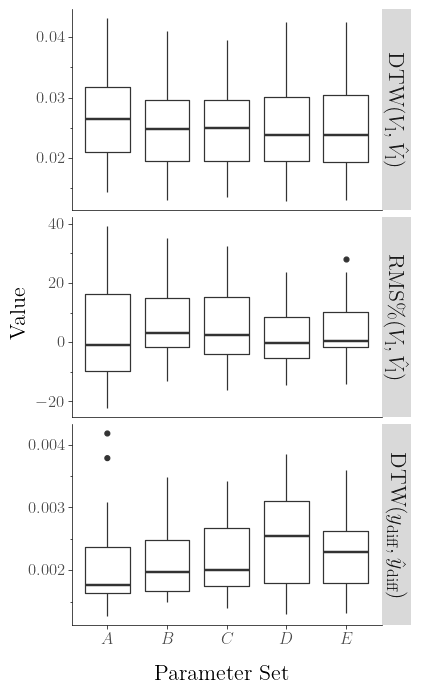

<ggplot: (8749738712457)>

In [70]:
from plotnine import *
from matplotlib import rc
rc('font', family='serif')
rc('text.latex', preamble=r'\usepackage{amsmath}')
rc('text', usetex=True)

df_plot = df_filtered_scores_melt[df_filtered_scores_melt['variable'].isin(['emf.dtw.euclid.norm', 'y.diff.dtw.euclid.norm', 'rms.perc.diff'])]
df_plot['value'] = df_plot['value'].astype(float)

cols_rename = {'emf.dtw.euclid.norm': r'$\text{DTW}(V_{\text{l}}, \hat{V}_{\text{l}})$',
               'y.diff.dtw.euclid.norm': r'$\text{DTW}(y_{\text{diff}},  \hat{y}_{\text{diff}})$',
               'rms.perc.diff': r'$\text{RMS\%}(V_{\text{l}}, \hat{V}_{\text{l}})$'}

lblr = labeller(rows=lambda y: cols_rename[y])

p = ggplot(aes(x='metric.name', y='value'), df_plot)
p = (
    p
    + geom_boxplot()
    + facet_grid('variable ~ .', scales='free_y', labeller=lblr)
    + phd_theme()
    + theme(figure_size=(4, 8))
    + xlab('Parameter Set')
    + ylab('Value')
)
#p.save('/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/metric_density.pdf', dpi=200)
p

In [18]:
import dask.dataframe as dd
from dask.distributed import Client
Client()

Client Scheduler: tcp://127.0.0.1:35861 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 24 Memory: 31.33 GiB


In [19]:
# Ok, let's try load the groundtruth
# Let's get some groundtruth in here
from unified_model import evaluate
from unified_model import metrics
from unified_model.utils.utils import collect_samples
from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import Any


@dataclass
class MechanicalGroundtruth:
    y_diff: Any
    time: Any

@dataclass
class ElectricalGroundtruth:
    emf: Any
    time: Any

@dataclass
class Groundtruth:
    mech: MechanicalGroundtruth
    elec: ElectricalGroundtruth

class GroundTruthFactory:
    def __init__(self,
                 samples_list,
                 lvp_kwargs,
                 adc_kwargs):
        """Helper Factory to get groundtruth data in a batch."""
        
        self.samples_list = samples_list
        self.lvp_kwargs = lvp_kwargs
        self.adc_kwargs = adc_kwargs

        self.lvp = evaluate.LabeledVideoProcessor(**lvp_kwargs)
        self.adc = evaluate.AdcProcessor(**adc_kwargs)

    def _make_mechanical_groundtruth(self, sample):
        y_target, y_time_target = self.lvp.fit_transform(
            sample.video_labels_df,
            impute_missing_values=True
        )
        y_target = savgol_filter(y_target, 9, 3)

        return MechanicalGroundtruth(y_target,
                                     y_time_target)

    def _make_electrical_groundtruth(self, sample):
        emf_target, emf_time_target = self.adc.fit_transform(sample.adc_df)
        return ElectricalGroundtruth(emf_target,
                                     emf_time_target)

    def make(self):
        groundtruths = []
        for sample in self.samples_list:
            try:
                mech_groundtruth = self._make_mechanical_groundtruth(sample)
                elec_groundtruth = self._make_electrical_groundtruth(sample)

                groundtruths.append(
                    Groundtruth(mech_groundtruth, elec_groundtruth)
                )
            except AttributeError:
                pass

        return groundtruths
# Prepare data
base_groundtruth_path = '../data/2019-05-23_D/'
samples = {}
samples['A'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='A/*acc*.csv',
                               adc_pattern='A/*adc*.csv',
                               video_label_pattern='A/*labels*.csv')
samples['B'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='B/*acc*.csv',
                               adc_pattern='B/*adc*.csv',
                               video_label_pattern='B/*labels*.csv')
samples['C'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='C/*acc*.csv',
                               adc_pattern='C/*adc*.csv',
                               video_label_pattern='C/*labels*.csv')



In [20]:
# Groundtruth

from unified_model.mechanical_components.magnet_assembly import MagnetAssembly
magnet_assembly = MagnetAssembly(
    m=1,
    l_m_mm=10,
    l_mcd_mm=0,
    dia_magnet_mm=10,
    dia_spacer_mm=10,
    mat_magnet='NdFeB',
    mat_spacer='iron'
)

groundtruth = {}
for device in ['A', 'B', 'C']:
    groundtruth_factory = GroundTruthFactory(samples[device],
                                            lvp_kwargs=dict(magnet_assembly=magnet_assembly,
                                                            seconds_per_frame=1/60,
                                                            pixel_scale=0.154508),
                                            adc_kwargs=dict(voltage_division_ratio=1 / 0.342))
    groundtruth[device] = groundtruth_factory.make()

In [21]:
magnet_assembly.get_weight()

0.05778566987196727

In [22]:
# Let's look at some examples from each

In [23]:
import dask.dataframe as dd 

def get_curve(df_curves_path, model_id, input_excitation_number):
    #df_curves = vaex.open(df_curves_path)[['model_id', 'input_excitation_number', 'device_id', 'time', 'emf', 'y_diff']]
    df_curves = dd.read_parquet(df_curves_path,
                                columns=['model_id', 'input_excitation', 'time', 'emf', 'y_diff'],
                                filters=[('input_excitation', '==', input_excitation_number)])
    df_temp = df_curves[df_curves['model_id'] == model_id]
    df_temp = df_temp[df_temp['input_excitation'] == input_excitation_number]
    df_temp = df_temp.compute()
    return df_temp.sort_values(by='time')

In [24]:
def compare_mech(df_curves_path, groundtruth, model_id, device, input_excitation_number):
    x = get_curve(df_curves_path, model_id, input_excitation_number)
    
    
    mech_eval = evaluate.MechanicalSystemEvaluator(
        y_target = groundtruth[device][input_excitation_number].mech.y_diff,  # Referenced to zero
        time_target = groundtruth[device][input_excitation_number].mech.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance}
    )

    mech_eval.fit(
        y_predict = x['y_diff'].values,
        time_predict = x['time'].values
    )
    print(mech_eval.score())
    mech_eval.poof(figsize=(16,8))
    del x

In [25]:
def compare_elec(df_curves_path, groundtruth, model_id, device, input_excitation_number):
    x = get_curve(df_curves_path, model_id, input_excitation_number)
    
    elec_eval = evaluate.ElectricalSystemEvaluator(
        emf_target=groundtruth[device][input_excitation_number].elec.emf,  # Referenced to zero
        time_target=groundtruth[device][input_excitation_number].elec.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance,
                  'rms_perc_diff': metrics.root_mean_square_percentage_diff}
    )
    
    elec_eval.fit(
        emf_predict=x['emf'].values,
        time_predict=x['time'].values
    )
    print(elec_eval.score())
    elec_eval.poof(figsize=(16, 8))
    del x
    return elec_eval

In [26]:
from scipy import signal

In [27]:
%matplotlib widget

In [28]:
best_model_ids

{'dtw_mech': 5675,
 'dtw_elec': 5705,
 'dtw_both': 5675,
 'rms_perc_abs': 6196,
 'rms_dtw_elec': 6196,
 'balanced': 5675}

In [33]:
input_ = 5
device = 'A'
chosen_model_id = 5675

compare_mech(f'../data/parameter_search/2021-03-19/{device}_augmented.parquet', groundtruth, chosen_model_id, device, input_)
ee = compare_elec(f'../data/parameter_search/2021-03-19/{device}_augmented.parquet', groundtruth, chosen_model_id, device, input_)

plt.figure(figsize=(16, 8))
plt.plot(ee.emf_predict_clipped_, 'r')
plt.plot(ee.emf_target_clipped_, 'k')

{'dtw_distance': 6.6364809173389725}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'dtw_distance': 59.2596681437002, 'rms_perc_diff': 10.395483574683666}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …